In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tqdm import tqdm, notebook
import dask
from scipy.stats import hmean

In [9]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import re

In [3]:
#https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl

In [58]:
prefix = 'transect'
inDIR = '../data/training/'
inFILE = 'vor_2014_2023_cln_2024_04_04_' + prefix + '_hls_idxs.csv'

In [252]:
df = pd.read_csv(os.path.join(inDIR, inFILE))

In [253]:
var_names = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']
y_col = 'Biomass_kg_ha'

df = df[~df[var_names + [y_col]].isnull().any(axis=1)].copy()

df['sqrt_Biomass_kg_ha'] = np.sqrt(df['Biomass_kg_ha']) 

df = df.reset_index(drop=True)

In [176]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/extract')
from hpc_setup import launch_dask
import psutil
interface_prefs = [
        'ibp175s0',
        'ibp59s0',
        'enp24s0f0',
        'ens7f0',
        'ibp24s0',
        'ib0'
    ]
interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
if len(interface) == 0:
    print('ERROR: Preferred interfaces not found on node!')
else:
    print(interface)
num_jobs=128
client = launch_dask(cluster_loc='hpc',
                     num_jobs=num_jobs,
                     num_processes=2,
                     num_threads_per_processes=2,
                     mem_gb_per=12.0,
                     partition='atlas', 
                     duration='2:00:00',
                     slurm_opts={'interface': interface},
                     extra_directives=["--account=cper_neon_aop"],
                     wait_proportion=0.25,
                    wait_timeout=240,
                    debug=False)
display(client)

ib0
   setting up cluster on HPC...


<Client: 'tcp://172.21.15.2:43853' processes=0 threads=0, memory=0 B>

In [18]:
#from distributed import get_client
#client = get_client()
#nthreads = len(client.nthreads())
#display(client)

In [29]:
def pls_dist_all(df, x_vars=var_names, y_var='sqrt_Biomass_kg_ha'):
    dfs_out = []
    
    X = df[x_vars]
    y = df[y_var]
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    pc = PLSRegression(n_components=12)
    pc.fit(X_scaled, y)

    df_tmp = df
    scores = pc.transform(scaler.transform(df_tmp[var_names]))

    pc_names = []
    naY = y
    r2_scores = []
    
    for j in range(scores.shape[1]):
        pc_names.append('PC' + str(j+1)) 
        df_tmp['PC'+str(j+1)] = scores[:,j]
        Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
        r2_scores.append(round(r2_score(y, Y_pred),3))
    idxs_out = []
    distances_mean = []
    distances_hmean = []
    distances_mean_within = []
    distances_hmean_within = []
    for row_idx, row in df_tmp.iterrows():
        point = row[pc_names].values.astype(float)
        other_points = df_tmp[(df_tmp.index != row_idx)][pc_names].values.astype(float)
        ec_wdistances = np.sqrt(np.sum(r2_scores*(other_points - point) ** 2, axis=1))
        distances_mean.append(np.mean(ec_wdistances))
        distances_hmean.append(hmean(ec_wdistances+1e-10))
        idxs_out.append(row_idx)
    df_out = pd.DataFrame({'distances_mean': distances_mean,
                           'distances_hmean': distances_hmean}, index=idxs_out)
    return df_out

In [38]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [63]:
df_dists_all = pls_dist_all(df)

In [64]:
df_dists_all

,distances_mean,distances_hmean
0,5.843048,4.288094
1,4.046190,2.348913
2,2.952883,1.803350
3,3.333602,2.108290
4,3.178698,2.046450
...,...,...
9646,2.530516,1.660156
9647,2.477256,1.590514
9648,2.529868,1.612190
9649,2.407208,1.523446


In [165]:
from sklearn.cluster import k_means

In [ ]:
df['Plot'] = df['Id'].apply(lambda x: '_'.join(x.split('_')[:-1]))

scaler = StandardScaler().fit(df[var_names])
X_scaled = scaler.transform(df[var_names])

pc = PLSRegression(n_components=3)
pc.fit(X_scaled, df['sqrt_Biomass_kg_ha'])
scores = pc.transform(scaler.transform(df[var_names]))

df_plot_scores = df.copy()
for i in range(scores.shape[1]):
    df_plot_scores['PC' + str(i)] = scores[:,i]

df_plot_scores = df_plot_scores.groupby(['Plot', 'Date_mean'])[[x for x in df_plot_scores.columns if 'PC' in x]].mean()#.reset_index()

centroid, label, inertia = k_means(df_plot_scores, n_clusters=10)

df_plot_scores['kfold'] = label.astype('str')

df_plot_scores = df_plot_scores.reset_index()
df = pd.merge(df, df_plot_scores[['Plot', 'Date_mean', 'kfold']], how='left', on=['Plot', 'Date_mean'])

In [198]:
@dask.delayed
def pls_dist(i, df_cv, x_vars=var_names,
             y_var='sqrt_Biomass_kg_ha'):
    dfs_out = []
    idxs_out = []
    X = df_cv[df_cv['kfold'] != i][x_vars]
    y = df_cv[df_cv['kfold'] != i][y_var]
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    pc = PLSRegression(n_components=12)
    pc.fit(X_scaled, y)

    df_tmp = df_cv
    scores = pc.transform(scaler.transform(df_tmp[var_names]))

    pc_names = []
    naY = y
    r2_scores = []
    
    for j in range(scores.shape[1]):
        pc_names.append('PC' + str(j+1)) 
        df_tmp['PC'+str(j+1)] = scores[:,j]
        Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
        r2_scores.append(round(r2_score(y, Y_pred),3))

    distances_mean = []
    distances_hmean = []
    distances_mean_within = []
    distances_hmean_within = []
    for row_idx, row in df_k_sub.iterrows():
        point = row[pc_names].values.astype(float)
        other_points = df_tmp[df_tmp['kfold'] != i][pc_names].values.astype(float)
        within_points = df_tmp[(df_tmp.index != row_idx) & (df_tmp['kfold'] == i)][pc_names].values.astype(float)
        ec_wdistances = np.sqrt(np.sum(r2_scores*(other_points - point) ** 2, axis=1))
        ec_wdistances_within = np.sqrt(np.sum(r2_scores*(within_points - point) ** 2, axis=1))
        distances_mean.append(np.mean(ec_wdistances))
        distances_hmean.append(hmean(ec_wdistances+1e-10))
        distances_mean_within.append(np.mean(ec_wdistances_within))
        distances_hmean_within.append(hmean(ec_wdistances_within+1e-10))
    dfs_out.append({'kfold': i,
                    'cv': df_tmp['cv'].unique().item(),
                    'distances_mean': np.mean(distances_mean),
                    'distances_hmean': np.mean(distances_hmean),
                    'distances_mean_within': np.mean(distances_mean_within),
                    'distances_hmean_within': np.mean(distances_hmean_within)})
    df_out = pd.DataFrame(dfs_out)
    return df_out

In [199]:
plot_results_tmp = [pls_dist(x, df_plot, centroids_only=False) for x in df_plot['kfold'].unique()]
plot_results = dask.compute(*plot_results_tmp)

In [68]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import re

In [69]:
def plot_pcs(df, ax, var_names, pc_type, var_reduce_type, k, vars_of_interest, title=None, n_comps=None, n_std=2.0, pcs=[1,2], topk=2):    
    # load data
    X = df[var_names]
    y = df['sqrt_Biomass_kg_ha']
    features = var_names
    X_scaled = StandardScaler().fit_transform(X)
    if n_comps is None:
        n_comps = len(var_names)
    pcs_idx = [i-1 for i in pcs]
    if pc_type == 'pca':
        features +=  ['sqrt_Biomass_kg_ha']
        # analysis
        pca = PCA(n_components=10).fit(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        X_reduced = pca.transform(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        # results
        scores = X_reduced[:, pcs_idx]
        loadings = pca.components_[pcs_idx].T
        pvars = pca.explained_variance_ratio_[pcs_idx] * 100
    elif pc_type == 'pls':
        pls2 = PLSRegression(n_components=n_comps)
        pls2.fit(X_scaled, y)
        loadings = pls2.x_loadings_[:,pcs_idx]
        scores = pls2.x_scores_[:, pcs_idx]
        naY = y
        r2_scores = []
        for i in range(0,n_comps):
            Y_pred=np.dot(pls2.x_scores_[:,i].reshape(-1,1),pls2.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y,Y_pred),3))
        pvars = np.array(r2_scores)[pcs_idx]*100
    
    if var_reduce_type == 'top_k':
        tops = (loadings ** 2).sum(axis=1).argsort()[-topk:]
    elif var_reduce_type == 'manual':
        tops = [i for i, value in enumerate(features) if value in vars_of_interest]
    
    if pc_type == 'pca':
        tops = [x for x in tops if (x+1) != len(features)]
    arrows = loadings[tops]
    arrows /= np.sqrt((arrows ** 2).sum(axis=0))
    arrows *= np.abs(scores).max(axis=0)
    
    if pc_type == 'pca':
        bm_arrow = loadings[-1]
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
    elif pc_type == 'pls':
        bm_arrow = pls2.y_loadings_[:,pcs_idx].squeeze()
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
        #bm_arrow *= np.abs(pls2.y_scores_).max(axis=0)
    
    for idx, i in enumerate(pcs):
        df['PC'+str(i)] = scores[:,idx]
    
    #plt.scatter(scores[:, 0], scores[:,1], s=8, alpha=0.5)
    sns.scatterplot(x='PC'+str(pcs[0]), y='PC'+str(pcs[1]), data=df, hue='Season',
                    edgecolor='none', alpha=0.3, s=6, palette='Greys', ax=ax)
    #ax.legend(title=None, loc='lower center', ncols=5)
    width = -0.005 * np.min([np.subtract(*ax.get_xlim()), np.subtract(*ax.get_ylim())])
    for i, arrow in zip(tops, arrows):
        ax.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
        ax.text(*(arrow * 1.3), features[i], ha='center', va='center', color='k')
    ax.arrow(0, 0, *bm_arrow, color='grey', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
    ax.text(*(bm_arrow * 1.2), 'Biomass', ha='center', va='center', color='grey')

    ax.set_xlim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    ax.set_ylim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    
    for idx, axis in enumerate('xy'):
        #getattr(plt, f'{axis}ticks')([])
        getattr(ax, f'set_{axis}label')(f'PC{pcs[idx]} ({pvars[idx]:.2f}%)')
    custom_lines = []
    kfold_labels = []
    for i, k in enumerate(df['kfold'].sort_values().unique()):
        custom_lines.append(Line2D([0], [0], 
                                   color=mpl.colormaps['tab10'].colors[i],
                                   lw=3))
        confidence_ellipse(df['PC'+str(pcs[0])][df['kfold'] == k], 
                           df['PC'+str(pcs[1])][df['kfold'] == k], 
                           ax,
                           edgecolor=mpl.colormaps['tab10'].colors[i],
                           n_std=n_std)
        if type(k) == np.float_:
            kfold_labels.append(str(int(k)))
        elif 'kfold' in k:
            kfold_labels.append(re.sub('kfold', '', k))
        else:
            kfold_labels.append(str(k))
    ax.legend(custom_lines, kfold_labels, frameon=False)
    ax.set_title(title, y=1.0)
    return ax

(-13.0, 13.0)

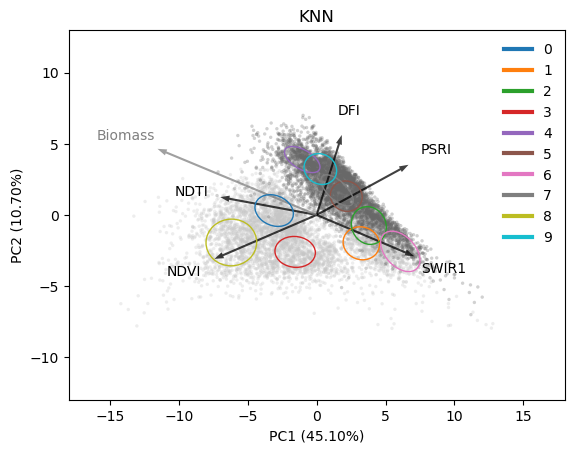

In [261]:
fig, ax = plt.subplots()
plot_pcs(df=df,
         ax=ax,
         var_names=var_names,
         pc_type = 'pls',
         var_reduce_type = 'manual',
         k=None,
         vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
         #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
         title='KNN',
         n_std=1.0,
         pcs=[1,2])
ax.set_xlim((-18, 18))
ax.set_ylim((-13, 13))

In [187]:
import random

In [190]:
random.shuffle(list(range(centroid.shape[0])))

In [195]:
rand_idxs = []
rand_labels = []
df['kfold_rand'] = ''
centroid_idxs = list(range(centroid.shape[0]))
random.shuffle(centroid_idxs)
for idx, i in enumerate(centroid_idxs):
    if idx < (centroid.shape[0] - 1):
        point = centroid[i].astype(float)
        #other_points = df.loc[[x for x in df.index if x not in rand_idxs]][var_names].values.astype(float)
        other_points = scores[[x for x in df.index if x not in rand_idxs], :]
        ec_wdistances = np.sum((other_points - point) ** 2, axis=1)
        avail_idxs = [x for x in df.index if x not in rand_idxs]
        rand_idxs_i = np.random.choice(avail_idxs, size=len(df)//10, replace=False, p=ec_wdistances/sum(ec_wdistances))
        rand_idxs.extend(rand_idxs_i)
        df.loc[rand_idxs_i, 'kfold_rand'] = str(i)
    else:
        df.loc[df['kfold_rand'] == '', 'kfold_rand'] = str(i)

In [196]:
df['kfold'] = df['kfold_rand']

In [197]:
df.groupby('kfold').value_counts(['Season'])

kfold  Season 
0      June       684
       October    280
1      June       543
       October    421
2      October    669
       June       295
3      June       527
       October    444
4      October    712
       June       252
5      June       533
       October    431
6      June       639
       October    325
7      October    524
       June       440
8      June       599
       October    365
9      October    644
       June       320
Name: count, dtype: int64

<Axes: title={'center': 'KNN'}, xlabel='PC1 (45.10%)', ylabel='PC2 (10.70%)'>

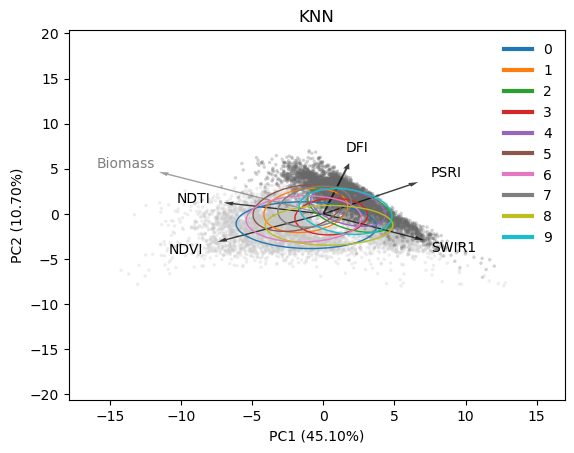

In [198]:
fig, ax = plt.subplots()
plot_pcs(df=df,
         ax=ax,
         var_names=var_names,
         pc_type = 'pls',
         var_reduce_type = 'manual',
         k=None,
         vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
         #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
         title='KNN',
         n_std=1.0,
         pcs=[1,2])

In [113]:
df.loc[df['kfold_rand'] == '', 'kfold_rand']

564     
574     
898     
3657    
8168    
9257    
9347    
Name: kfold_rand, dtype: object

In [27]:
names = ['Plot (random k-fold)', 'Pasture (spatial block)', 'Ecosite (spatial strata)', 'Year (temporal)']

In [28]:
df_plot['kfold'].unique()

['kfold1', 'kfold2', 'kfold3', 'kfold4', 'kfold9', 'kfold10', 'kfold7', 'kfold6', 'kfold8', 'kfold5']
Categories (10, object): ['kfold1', 'kfold2', 'kfold3', 'kfold4', ..., 'kfold7', 'kfold8', 'kfold9', 'kfold10']

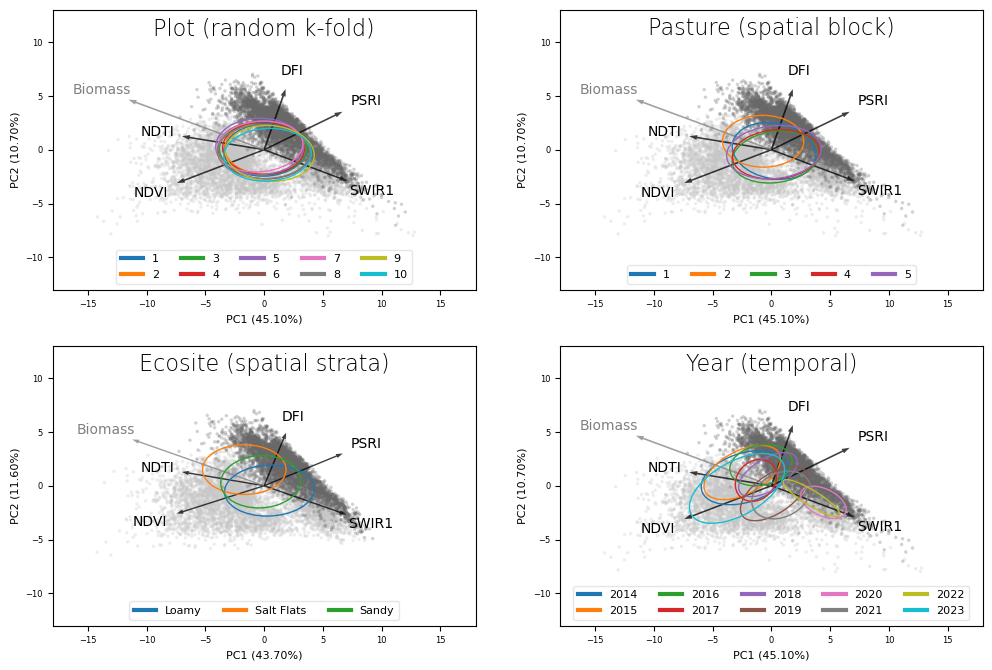

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for idx, df in enumerate([df_plot, df_spatial, df_ecosite, df_year]):
    df['sqrt_Biomass_kg_ha'] = np.sqrt(df['Biomass_kg_ha']) 
    plot_pcs(df=df,
             ax=axs.flatten()[idx],
             var_names=var_names,
             pc_type = 'pls',
             var_reduce_type = 'manual',
             k=None,
             vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
             #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
             title=names[idx],
             n_std=1.0,
             pcs=[1,2])
    leg = axs.flatten()[idx].get_legend()
    #if idx > 1:
    leg.set_loc('lower center')
    #handles, labels = axs.flatten()[idx].get_legend_handles_labels()
    axs.flatten()[idx].legend(leg.legend_handles,
                              [x.get_text() for x in leg.get_texts()], 
                              ncol=5, loc='lower center',
                              frameon=True, framealpha=0.5, 
                              fontsize=8)
    #else:
    #    leg.set_visible(False)
for ax in axs.flatten():
    ax.title.set(fontweight=10, fontsize=16, y=0.88)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    ax.set_xlim((-18, 18))
    ax.set_ylim((-13, 13))